# Vectorized Execution in SparkR

This nootebook demonstrates Arrow optimization with some small data (~10 MB) so that people can actually try out and refer when they run the benchmark in an actual cluster.

**Note that** the performance improves far more greatly when the size of data is large. Given my benchmark with [500000 Records](http://eforexcel.com/wp/downloads-16-sample-csv-files-data-sets-for-testing/) dataset, I have observed up to around **1000% ~ 5000%** improvement.
For more details, see [Databricks' blog](https://databricks.com/blog/2018/08/15/100x-faster-bridge-between-spark-and-r-with-user-defined-functions-on-databricks.html).

## Preparation

First, enable R cell magic to execute R codes in Jupyter.

In [1]:
import rpy2.rinterface
%load_ext rpy2.ipython

After that, prepare data to use. In this simple benchmark, [10000 Records](http://eforexcel.com/wp/downloads-16-sample-csv-files-data-sets-for-testing/) dataset is used.

In [2]:
import urllib.request
from zipfile import ZipFile
from io import BytesIO

# `rownum` can be 10000, 50000, 100000, ....
# See http://eforexcel.com/wp/downloads-16-sample-csv-files-data-sets-for-testing/
rownum = 10000

url = "http://eforexcel.com/wp/wp-content/uploads/2017/07/%s-Records.zip" % rownum
ZipFile(BytesIO(urllib.request.urlopen(url).read())).extractall()

Initialize SparkR with enough memory and load libraries used for benchmarking. In this benchmark, it used 1 for shuffle and default parallelism to mimic the case when the large dataset is processed.

In [3]:
%%R
library(SparkR, lib.loc = c(file.path(Sys.getenv("SPARK_HOME"), "R", "lib")))
# Let's limit core; otherwise, Jupyter might die on some heavy workload.
sparkR.session(master = "local[1]")
library(microbenchmark)

R[write to console]: 
Attaching package: ‘SparkR’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window


R[write to console]: The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union


R[write to console]: Spark package found in SPARK_HOME: /home/jovyan/spark



Launching java with spark-submit command /home/jovyan/spark/bin/spark-submit   sparkr-shell /tmp/Rtmpokvb6k/backend_portf2336d89cd39 


Prepare R DataFrame to test from the data downloaded above.

In [4]:
%%R
# `rownum` can be 10000, 50000, 100000, ....
# See http://eforexcel.com/wp/downloads-16-sample-csv-files-data-sets-for-testing/
rownum <- 10000
df <- read.csv(paste0(rownum, " Records.csv"))
print(object.size(df), units = "MB")
# To load `createDataFrame` faster, let's turn on Arrow optimization
sparkR.session(sparkConfig = list(spark.sql.execution.arrow.sparkr.enabled = "true"))
spark_df <- cache(createDataFrame(df))
num <- count(spark_df)  # trigger the count to make sure input DataFrame is cached.

9.9 Mb


Prepare the common function to use for the benchmarking.

In [5]:
%%R
benchmark_arrow <- function(func) {
    microbenchmark("No Arrow" = {
                     sparkR.session(sparkConfig = list(spark.sql.execution.arrow.sparkr.enabled = "false"))
                     func()
                   },
                   "Arrow" = {
                     sparkR.session(sparkConfig = list(spark.sql.execution.arrow.sparkr.enabled = "true"))
                     func()
                   }, times = 3L)
}

## R DataFrame to Spark DataFrame

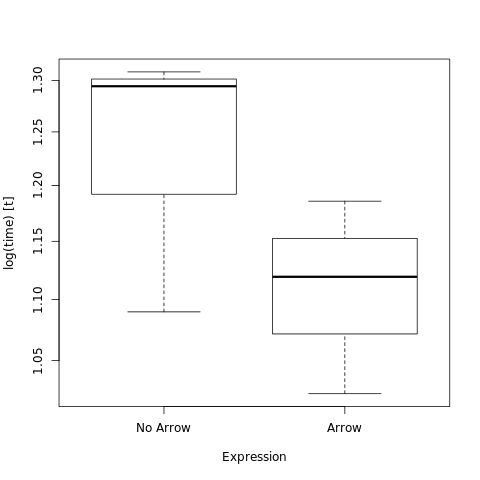

In [6]:
%%R
func <- function() { createDataFrame(df) }
boxplot(benchmark_arrow(func))

## Spark DataFrame to R DataFrame

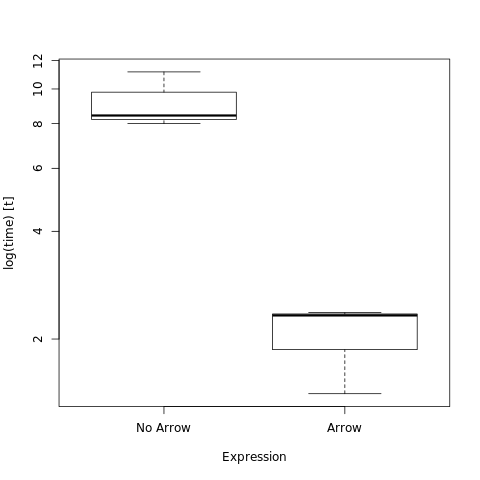

In [7]:
%%R
func <- function() { collect(spark_df) }
boxplot(benchmark_arrow(func))

## `dapply`

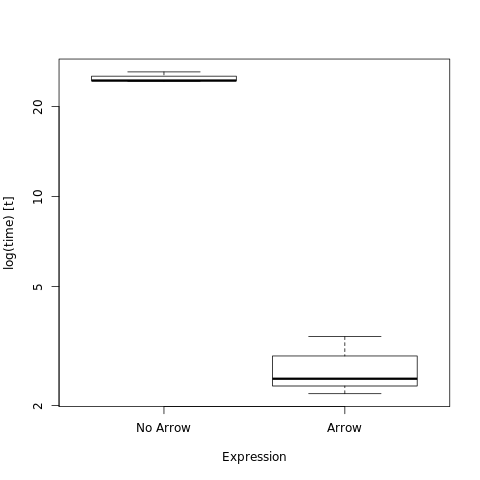

In [8]:
%%R
func <- function() { count(dapply(spark_df, function(rdf) { rdf }, schema(spark_df))) }
boxplot(benchmark_arrow(func))

## `gapply`

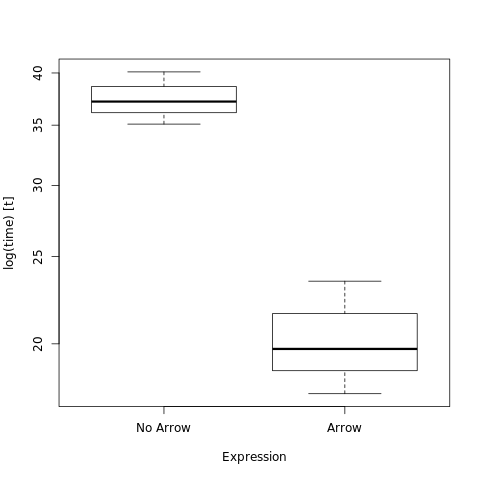

In [9]:
%%R
func <- function() {
  count(gapply(spark_df,
               "Month_of_Joining",
               function(key, group) { group }, schema(spark_df)))
}
boxplot(benchmark_arrow(func))